In [1]:
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

from score_models.trainer import trainer
from score_models.models.mlp.mlp import MLPScoreModel
from score_models.train_steps.ddpm_train_step import TrainStepDDPM
from score_models.utils.data import guassian_mixture
from score_models.utils.noise import get_betas
from score_models.sampling import ddpm_sampling
from score_models.utils.warmup_scheduler import WarmUpScheduler

In [2]:
# load dataset
dataset = guassian_mixture(N=10_000)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [3]:
device = "cuda"
input_size = 2
hidden_size = 32
T = 1000
lr = 1e-4
weight_decay = 1e-4

# define score model and optimizer
score_model = MLPScoreModel(input_size=input_size, hidden_size=hidden_size, T=T).to(device)
optimizer = optim.AdamW(score_model.parameters(), lr=lr, weight_decay=weight_decay)


# Create a chained scheduler
num_steps = 200_000
warmup_steps = int(0.1 * num_steps)

# define scheduler
warmup_steps = int(0.1 * num_steps)
scheduler = CosineAnnealingLR(optimizer, T_max=num_steps - warmup_steps)
warmup_scheduler = WarmUpScheduler(
    optimizer=optimizer,
    lr_scheduler=scheduler,
    warmup_steps=warmup_steps,
    warmup_start_lr=0.0,
    warmup_mode="linear",
)

# define train step (i.e., criterion)
beta_min, beta_max = 1e-4, 2e-2
betas = get_betas(beta_min=beta_min, beta_max=beta_max, T=T)
train_step = TrainStepDDPM(score_model=score_model, alphas_bar=betas["alphas_bar"])


In [4]:
score_model = trainer(
    train_step=train_step,
    model=score_model,
    train_loader=dataloader,
    optimizer=optimizer,
    scheduler=warmup_scheduler,
    num_steps=num_steps,
    log_every=10_000,
    save_every=50_000,
    batch_preprocessor=lambda x: (x.to(device), ),
)

  0%|          | 30/200000 [00:00<40:01, 83.28it/s]  

Step 1, Loss: 2.5893. LR: 0.0001e-4


  5%|▌         | 10037/200000 [00:33<11:02, 286.65it/s]

Step 10000, Loss: 1.1933. LR: 0.5000e-4


 10%|█         | 20055/200000 [01:07<10:24, 288.03it/s]

Step 20000, Loss: 1.1316. LR: 1.0000e-4


 15%|█▌        | 30047/200000 [01:40<09:07, 310.52it/s]

Step 30000, Loss: 1.0700. LR: 0.9924e-4


 20%|██        | 40043/200000 [02:12<09:19, 285.77it/s]

Step 40000, Loss: 0.9459. LR: 0.9698e-4


 25%|██▌       | 50029/200000 [02:44<08:13, 303.97it/s]

Step 50000, Loss: 0.8434. LR: 0.9330e-4


 30%|███       | 60063/200000 [03:16<07:13, 322.68it/s]

Step 60000, Loss: 0.8233. LR: 0.8830e-4


 35%|███▌      | 70050/200000 [03:46<06:41, 323.46it/s]

Step 70000, Loss: 0.8127. LR: 0.8214e-4


 40%|████      | 80061/200000 [04:18<06:19, 315.96it/s]

Step 80000, Loss: 0.8079. LR: 0.7500e-4


 45%|████▌     | 90028/200000 [04:49<05:36, 326.43it/s]

Step 90000, Loss: 0.7807. LR: 0.6710e-4


 50%|█████     | 100059/200000 [05:20<05:07, 324.63it/s]

Step 100000, Loss: 0.7446. LR: 0.5868e-4


 55%|█████▌    | 110048/200000 [05:52<04:33, 329.24it/s]

Step 110000, Loss: 0.7558. LR: 0.5000e-4


 60%|██████    | 120041/200000 [06:23<04:07, 323.27it/s]

Step 120000, Loss: 0.7048. LR: 0.4132e-4


 65%|██████▌   | 130032/200000 [06:56<03:52, 300.50it/s]

Step 130000, Loss: 0.7912. LR: 0.3290e-4


 70%|███████   | 140047/200000 [07:29<03:25, 291.37it/s]

Step 140000, Loss: 0.7609. LR: 0.2500e-4


 75%|███████▌  | 150038/200000 [08:03<02:51, 290.55it/s]

Step 150000, Loss: 0.7307. LR: 0.1786e-4


 80%|████████  | 160045/200000 [08:36<02:14, 296.62it/s]

Step 160000, Loss: 0.7433. LR: 0.1170e-4


 85%|████████▌ | 170049/200000 [09:09<01:40, 297.76it/s]

Step 170000, Loss: 0.7138. LR: 0.0670e-4


 90%|█████████ | 180028/200000 [09:43<01:09, 287.02it/s]

Step 180000, Loss: 0.7140. LR: 0.0302e-4


 95%|█████████▌| 190046/200000 [10:17<00:33, 296.84it/s]

Step 190000, Loss: 0.7542. LR: 0.0076e-4


100%|██████████| 200000/200000 [10:51<00:00, 307.18it/s]

Step 200000, Loss: 0.7413. LR: 0.0000e-4


In [5]:
x = torch.randn(500, 2).to(device)
samples = ddpm_sampling(
    x=x,
    score_model=score_model,
    alphas=betas["alphas"],
    alphas_bar=betas["alphas_bar"],
    sigmas=betas["sigmas"],
    T=T
).cpu().numpy()

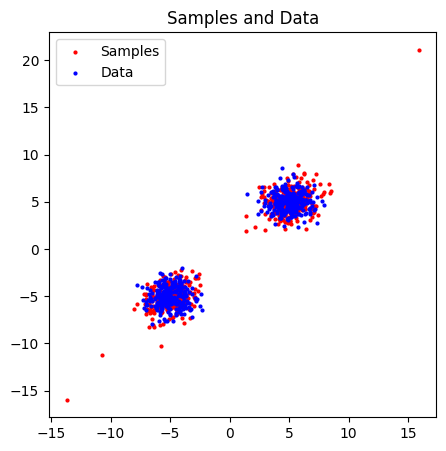

In [6]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
ax.scatter(samples[:, 0], samples[:, 1], color='red', s=4, label='Samples')
ax.scatter(dataset[:500][:, 0], dataset[:500][:, 1], color='blue', s=4, label='Data')
ax.set_title('Samples and Data')
plt.legend();